## Introduction

This notebook demonstrates how to:

- Create a derived valuation property and then use this property to create a summary column in the rebalance dashboard.
- Create a time variant portfolio property representing Total Net Assets (TNA) which can be populated from a 3rd party source, and then a derived valuation property which compares this to the LUSID calculated TNA. It then demonstrates how to:
    - View the outputs of the time variant TNA values in luminesce.
    - How to view the difference in a valuation and the rebalance dashboard.

## Setup

In [3]:
from pprint import pprint
import lusid
import lusid.models as lm
import lusid_drive
import os
# from lusidjam import RefreshingToken
# from fbnsdkutilities import ApiClientFactory
from lusid_drive import SyncApiClientFactory as ApiClientFactoryDrive
from lusid_drive import ApplicationMetadataApi
import pandas as pd
# from lusid_drive import Api

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# api_client_factory = lusid.utilities.ApiClientFactory( 
#    api_secrets_filename=secrets_path
# )

# api_client_factory = lusid.ApiClientFactory(
#    api_secret=secrets_path
# )

from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)


# Get URL and use it to configure Workflow and Drive SDKs
api_url = api_factory.api_client.configuration.host.strip("/api")
drive_configuration = lusid_drive.Configuration(host=api_url + "/drive")
drive_configuration.access_token = api_factory.api_client.configuration.access_token

# Setup Drive Client
drive_client = lusid_drive.ApiClient(drive_configuration)

property_api = api_factory.build(lusid.api.PropertyDefinitionsApi)
txn_portfolio_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)

files_api = lusid_drive.FilesApi(drive_client)
search_api = lusid_drive.SearchApi(drive_client)
# files_api = api_client_factory_drive.build(lusid_drive.api.FilesApi)
# search_api = api_client_factory_drive.build(lusid_drive.api.SearchApi)

## Variables Setup

In [4]:
my_scope = "FinbourneUniversity"

derived_valuation_property_domain = "DerivedValuation"
derived_valuation_property_scope = my_scope
derived_valuation_property_code = "CashAtBroker"
derived_valuation_property_display_name = "Cash At Broker"
derived_valuation_property_value = "Valuation/ExposureInReportCcy"

SHK_domain = "Transaction"
SHK_scope = my_scope
SHK_1_name = "CashFlag"
SHK_2_name = "ActivityFlag"
SHK_1_value = "MARGIN"
SHK_2_value = "CASH"

# Creating a summary property for the rebalance dashboard

## Create a derived valuation property

This is for creating a derived valuation property for the first time. Please see the below cell for how to update an existing derived valuation property.

In [5]:
create_derived_property_definition_request = lm.CreateDerivedPropertyDefinitionRequest(
    domain = derived_valuation_property_domain,
     scope = derived_valuation_property_scope,
     code = derived_valuation_property_code,
     display_name = derived_valuation_property_display_name,
     data_type_id = {"scope":"system","code":"number"},
     property_description = "",
     derivation_formula = f"""IF (PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_1_name}] eq '{SHK_1_value}'
         and PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_2_name}] eq '{SHK_2_value}')
             THEN AddressKeys[{derived_valuation_property_value}]
             ELSE 0"""
)

try:
    api_response = property_api.create_derived_property_definition(create_derived_property_definition_request)
    pprint(api_response)
except Exception as e:
    print("Exception when calling PropertyDefinitionsApi->create_derived_property_definition: %s\n" % e)

Exception when calling PropertyDefinitionsApi->create_derived_property_definition: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 21 Oct 2024 10:09:27 GMT', 'Content-Type': 'application/problem+json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'x-rate-limit-limit': '1m', 'x-rate-limit-remaining': '4999', 'x-rate-limit-reset': '2024-10-21T10:10:25.3562191Z', 'lusid-meta-success': 'False', 'lusid-meta-requestid': '0HN7H3U45HM68:000000C3', 'lusid-meta-correlationid': '0HN7H3U45HM68:000000C3', 'lusid-meta-duration': '1678', 'x-envoy-upstream-service-time': '2881', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains', 'Server': 'FINBOURNE', 'Content-Security-Policy': "default-src 'self' https://*.lusid.com https://*.finbourne.com; script-src 'unsafe-inline' 'self' https://*.lusid.com https://*.finbourne.com https://editor.swagger.io; font-src 'self' fonts.googleapis.com; img-src data: 'self' https://*.lusid.com https://*.finbour

## Update the derived valuation property

This is useful if you have created a derived valuation property but would now like to change the derivation formula.

In [8]:
update_derived_property_definition_request = lm.UpdateDerivedPropertyDefinitionRequest(
    display_name = derived_valuation_property_display_name,
    data_type_id = {"scope":"system","code":"number"},
     property_description = "",
     derivation_formula = f"""IF (PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_1_name}] eq '{SHK_1_value}'
         and PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_2_name}] eq '{SHK_2_value}')
             THEN AddressKeys[{derived_valuation_property_value}]
             ELSE 0"""
)

try:
    api_response = property_api.update_derived_property_definition(derived_valuation_property_domain, derived_valuation_property_scope, derived_valuation_property_code, update_derived_property_definition_request)
    pprint(api_response)
except Exception as e:
    print("Exception when calling PropertyDefinitionsApi->update_derived_property_definition: %s\n" % e)

{'code': 'CashAtBroker',
 'collection_type': None,
 'constraint_style': None,
 'data_type_id': {'code': 'number', 'scope': 'system'},
 'derivation_formula': 'IF '
                       '(PortfolioHolding.SubHoldingKeys[Transaction/FinbourneUniversity/CashFlag] '
                       "eq 'MARGIN'\n"
                       '         and '
                       'PortfolioHolding.SubHoldingKeys[Transaction/FinbourneUniversity/ActivityFlag] '
                       "eq 'CASH')\n"
                       '             THEN '
                       'AddressKeys[Valuation/ExposureInReportCcy]\n'
                       '             ELSE 0',
 'display_name': 'Cash At Broker',
 'domain': 'DerivedValuation',
 'href': None,
 'key': 'DerivedValuation/FinbourneUniversity/CashAtBroker',
 'life_time': 'Perpetual',
 'links': [{'description': None,
            'href': 'https://fbn-katy.lusid.com/api/api/schemas/entities/PropertyDefinition',
            'method': 'GET',
            'relation': 'Entity

## Clean-up: Delete the properties

In [9]:
try:
    # DeletePropertyDefinition: Delete property definition
    api_response = property_api.delete_property_definition(derived_valuation_property_domain, derived_valuation_property_scope, derived_valuation_property_code)
    pprint(api_response)
except lusid.ApiException as e:
    print("Exception when calling PropertyDefinitionsApi->delete_property_definition: %s\n" % e)

{'as_at': datetime.datetime(2024, 10, 21, 10, 11, 23, 84661, tzinfo=tzutc()),
 'effective_from': datetime.datetime(1, 1, 1, 0, 0, tzinfo=tzutc()),
 'entity_type': 'PropertyDefinition',
 'entity_unique_id': 'fa108043-4c7e-4b08-a294-540035d02233',
 'href': 'https://fbn-katy.lusid.com/api/api/entities/propertydefinitions/fa108043-4c7e-4b08-a294-540035d02233?effectiveAt=0001-01-01T00%3A00%3A00.0000000%2B00%3A00&asAt=2024-10-21T10%3A11%3A23.0846610%2B00%3A00',
 'links': [{'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'https://fbn-katy.lusid.com/app/insights/logs/0HN7H3U45HMB0:00000008',
            'method': 'GET',
            'relation': 'RequestLogs'}],
 'staged_modifications': {'count_pending': 0,
                          'href_pending': 'https://fbn-katy.lusid.com/api/api/stagedmodifications/?asAt=2024-10-21T10%3A11%3A23.0846610%2B00%3A00&filter=entityUniqueId%20eq%20%27fa108043-4c7e-4b0

## Checking the Valuations dashboard

Check your valuations dashboard to confirm your set-up. In this example I have Cash Flag and Activity Flag Transaction Domain properties as Sub Holding Keys (SHKs), as well as the previously set-up "Cash At Broker" derived valuation property, which will display the Exposure in Report Currency when CashFlag = MARGIN and ActivityFlag = CASH. By default this whole dashboard is grouped as one, so all sum columns are displaying the same values in every row.

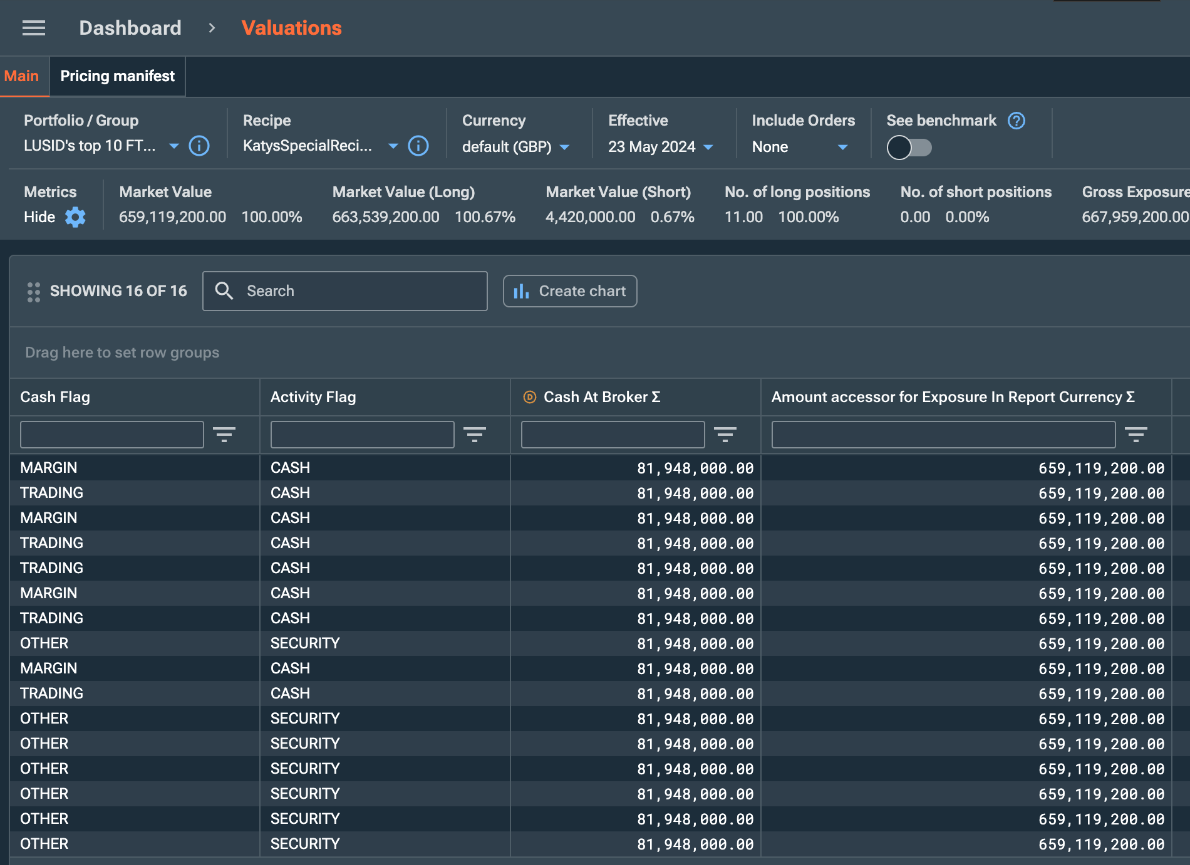


You can drag and drop the SHKs to see a more sensible view grouped by the SHKs, so Sum columns are now showing the summed values grouped by SHK, and we can see that the "Cash At Broker" property is correctly only populating with the exposure values when the CashFlag = MARGIN and ActivityFlag = CASH.

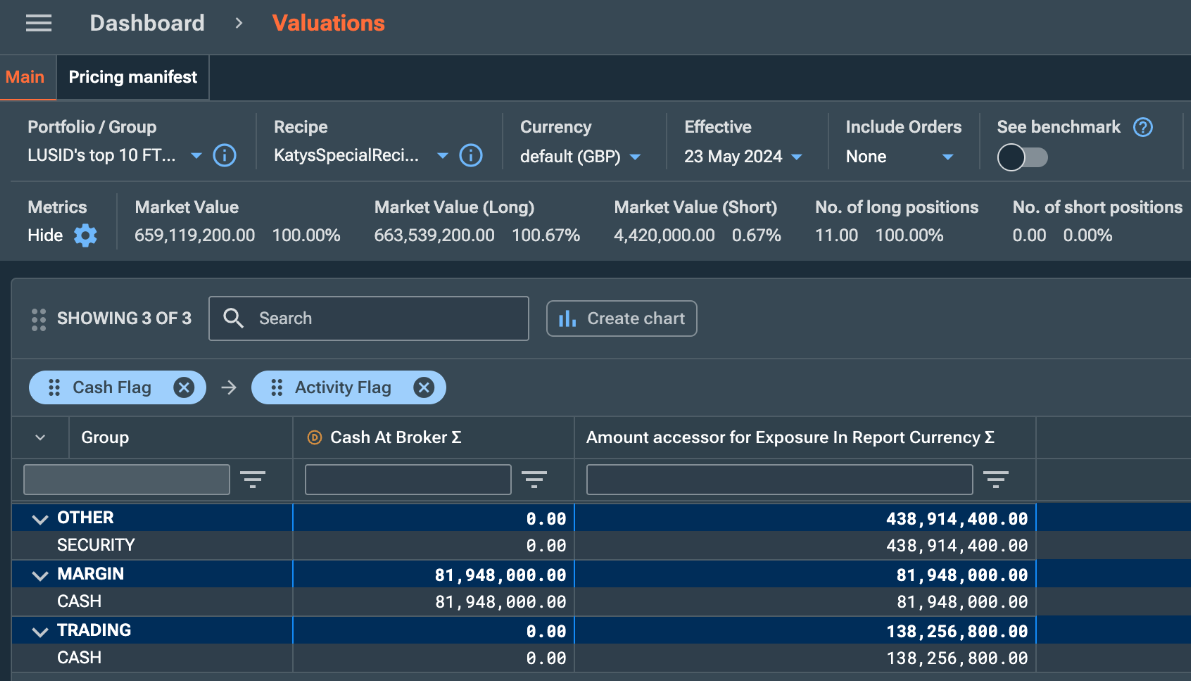

## Adding your derived valuation property to the rebalance dashboard

In your rebalance dashboard you can now add a column for your new "Cash At Broker" property with the sum operation into the top summary line of the dashboard:

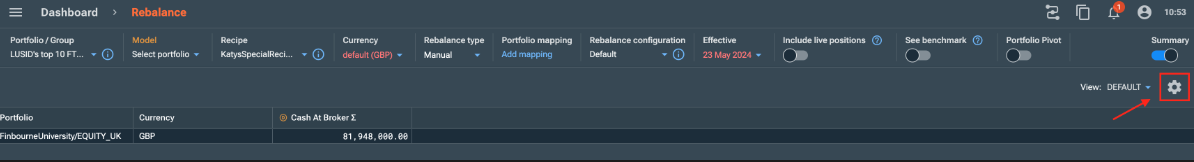

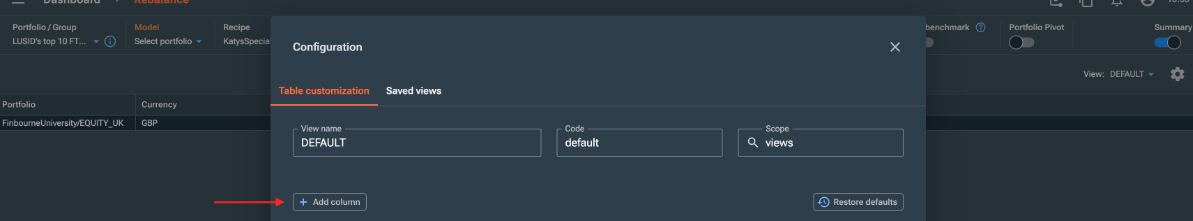

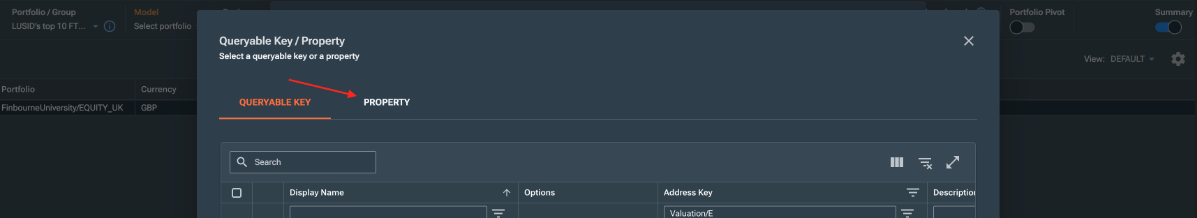

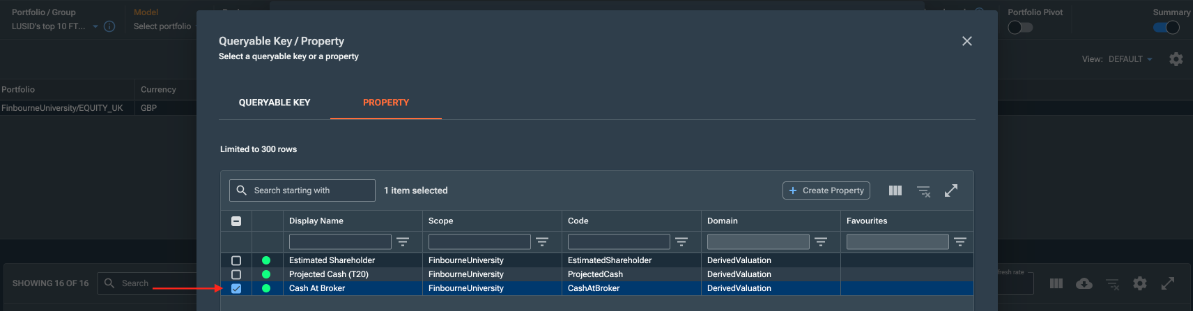

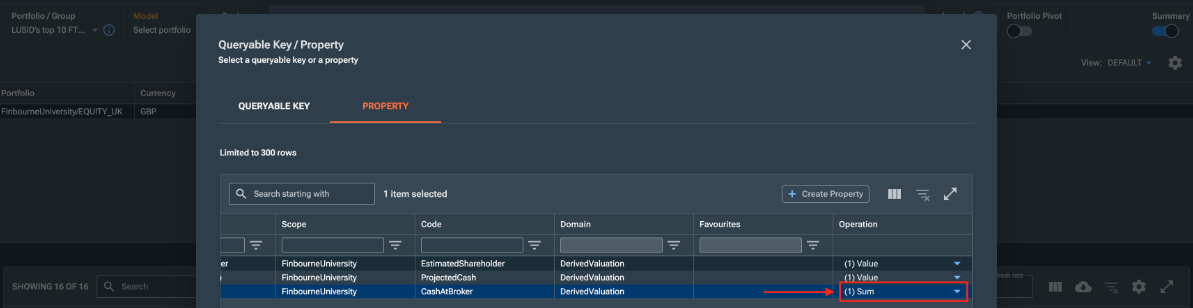

Submit and save, and you can now see a summary line for Cash At Broker in your rebalance dashboard:

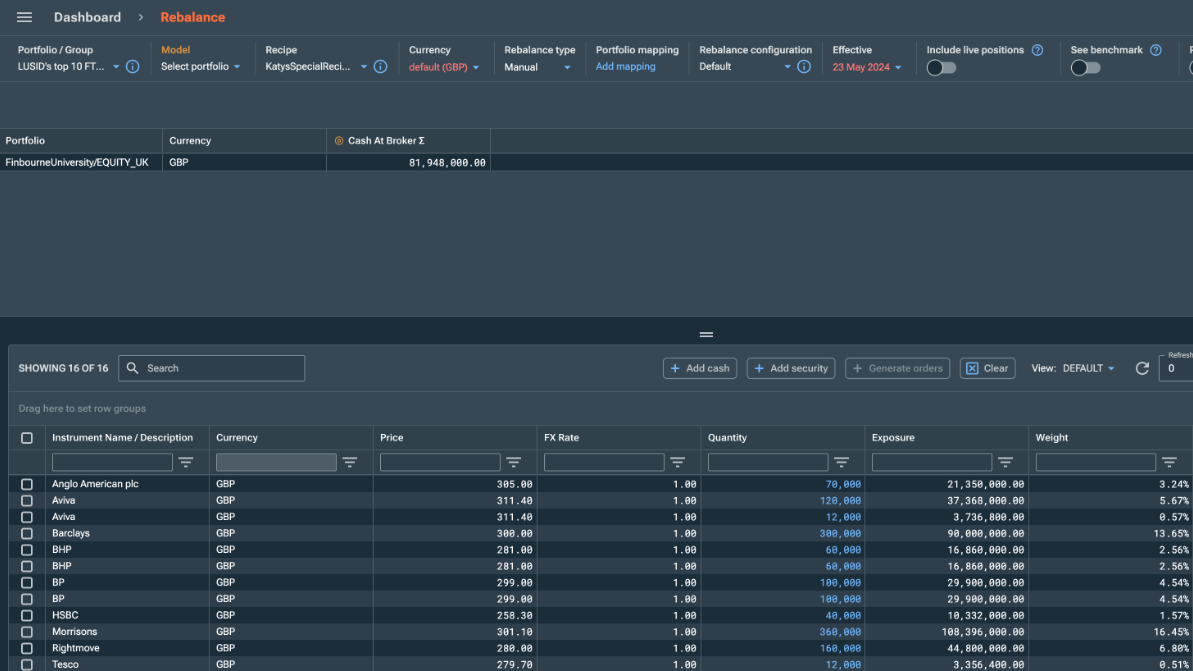

# Displaying the % difference between a LUSID calculated value and an external value

## Create a time variant portfolio property definition

This is a property definition which can be used to store the market valuation of each portfolio that has been calculated by another system. This step only creates the property definition, you will need to add this property to your portfolios and upload values for each portfolio.

In [10]:
property_code = 'MarketValuation'

create_property_definition_request = lm.CreatePropertyDefinitionRequest(
    domain='Portfolio',
    scope=my_scope,
    code=property_code,
    display_name='Market Valuation',
    data_type_id={"scope":"system","code":"number"},
    life_time="TimeVariant"
)

try:
    # CreatePropertyDefinition: Create property definition
    api_response = property_api.create_property_definition(create_property_definition_request)
    pprint(api_response)
except lusid.ApiException as e:
    print("Exception when calling PropertyDefinitionsApi->create_property_definition: %s\n" % e)

Exception when calling PropertyDefinitionsApi->create_property_definition: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 21 Oct 2024 10:12:23 GMT', 'Content-Type': 'application/problem+json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'x-rate-limit-limit': '1m', 'x-rate-limit-remaining': '4999', 'x-rate-limit-reset': '2024-10-21T10:13:22.8012534Z', 'lusid-meta-success': 'False', 'lusid-meta-requestid': '0HN7H3TKJ7PES:00000033', 'lusid-meta-correlationid': '0HN7H3TKJ7PES:00000033', 'lusid-meta-duration': '261', 'x-envoy-upstream-service-time': '1424', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains', 'Server': 'FINBOURNE', 'Content-Security-Policy': "default-src 'self' https://*.lusid.com https://*.finbourne.com; script-src 'unsafe-inline' 'self' https://*.lusid.com https://*.finbourne.com https://editor.swagger.io; font-src 'self' fonts.googleapis.com; img-src data: 'self' https://*.lusid.com https://*.finbourne.com ht

This cell should show an easy way to update all of your portfolios to have a value for this but where should we get the data from...???

## Create a derived valuation property
.. that accesses that property and calculates a % delta between IBOR EOD/SOD TNA and the current calc'd TNA in LUSID

In [ ]:
create_derived_property_definition_request = lm.CreateDerivedPropertyDefinitionRequest(
    domain = derived_valuation_property_domain,
     scope = my_scope,
     code = "MarketValuationDelta",
     display_name = "Market Valuation Delta",
     data_type_id = {"scope":"system","code":"number"},
     property_description = "",
    #  derivation_formula = f"""IF (PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_1_name}] eq '{SHK_1_value}'
    #      and PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_2_name}] eq '{SHK_2_value}')
    #          THEN AddressKeys[{derived_valuation_property_value}]
    #          ELSE 0"""
    derivation_formula = f""" IF(AddressKeys[Valuation/TotalPortfolioPvInPortfolioCcy] EQ 0) THEN
                                0›
                                ELSE
                                Properties[Portfolio/{my_scope}/{property_code}] /
                                AddressKeys[Valuation/TotalPortfolioPvInPortfolioCcy] """
)

try:
    api_response = property_api.create_derived_property_definition(create_derived_property_definition_request)
    pprint(api_response)
except Exception as e:
    print("Exception when calling PropertyDefinitionsApi->create_derived_property_definition: %s\n" % e)